# 本章要点

机器学习的根本问题：**优化**与**泛化**之间的矛盾。
- 机器学习模型的评估方法
- 改进模型拟合的最佳做法
- 提高泛化能力的最佳做法 <p>

机器学习的核心难题：**过拟合**。<p>

强调以下两点的重要性：
- 准确的模型评估
- 训练与泛化之间的平衡

# 泛化：机器学习的目标

在前面的二分类、多分类以及回归的例子中，我们将数据划分为训练集、验证集和测试集。不在同样的训练数据上评估模型的原因：仅仅几轮过后，模型在前所未见的数据上的性能就开始与训练数据上的性能发生偏离，后者总是随着训练而提高。模型开始**过拟合**。<p>
**优化**：是指调节模型使其在训练数据上得到最佳性能的过程。 <p>
**泛化**：是指训练好的模型在前所未见的数据上的性能。

## 欠拟合和过拟合

![典型的过拟合情况](images/典型的过拟合情况.png "典型的过拟合情况") <p>
随着训练的进行，模型在留出的验证数据上的性能开始提高，然后不可避免地一段时间后达到峰值。<p>
训练开始时，优化和泛化是相关的：训练数据上的损失越小，测试数据上的损失也越小。这时，模型是**欠拟合**的，即仍有改进的空间，模型还没有对训练数据中的所有相关模式建模。但在训练数据上迭代一定次数之后，泛化能力就不再提高，验证指标先是不变，然后开始变差。这时模型开始**过拟合**。 <p>
数据的不确定性很大或者包含罕见的特征，那么模型特别容易出现过拟合。比如：
- **嘈杂的训练数据**
- **模糊特征**
- **罕见特征与虚假的相关性**

### 以MNIST为例

将784个白噪声维度连接到现有的784个数据维度，从而创建一个新的训练集：现在一半的数据都是噪声。为了对比，还可以连接784个全零维度来创建一个等效的数据集。

#### 向MNIST数据集添加白噪声通道或全零通道

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
# 白噪声通道
train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)
# 全零通道
train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

#### 对于带有噪声通道或全零通道的MNIST数据，训练相同的模型

In [3]:
from tensorflow import keras 
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# 带有噪声通道的MNIST数据，训练相同模型
model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, 
    train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

# 带有全零通道的MNIST数据，训练相同模型
model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 6ms/step - loss: 0.6117 - accuracy: 0.8115 - val_loss: 0.3165 - val_accuracy: 0.9021
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 0.2527 - accuracy: 0.9222 - val_loss: 0.2237 - val_accuracy: 0.9321
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1664 - accuracy: 0.9485 - val_loss: 0.1867 - val_accuracy: 0.9402
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1189 - accuracy: 0.9630 - val_loss: 0.1501 - val_accuracy: 0.9549
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0879 - accuracy: 0.9721 - val_loss: 0.1542 - val_accuracy: 0.9536
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0652 - accuracy: 0.9793 - val_loss: 0.1141 - val_accuracy: 0.9657
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0503 - accuracy: 0.9842 - val_loss: 0.1157 - val_accuracy: 0.9653
Epoch 

#### 绘图比较验证精度

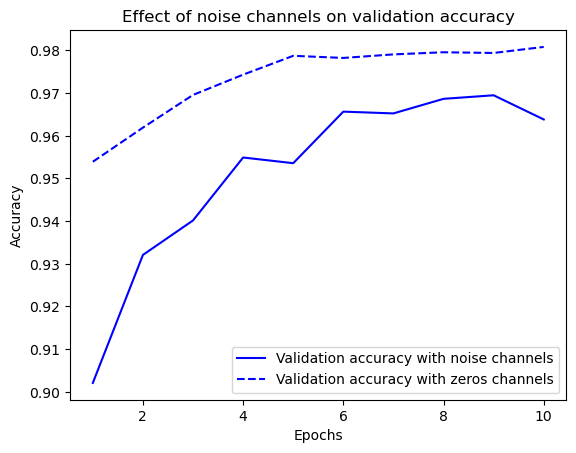

In [4]:
import matplotlib.pyplot as plt

val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-", label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--", label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

噪声特征不可避免会避免会导致过拟合。因此，如果不确定特征究竟是有用的还是无关紧要的，那么常见的做法是在训练前进行**特征选择**。<p>
**特征选择常用的方法**：对每个特征计算有用性分数，并且只保留那些分数高于某个阈值的特征。<p>
**有用性分数**：是用于衡量特征对于任务来说所包含信息量大小的指标，比如特征与标签之间的互信息。

## 深度学习泛化的本质

深度学习模型值的注意的是：只要模型具有足够的表示能力，就可以训练模型拟合任何数据。

### 将标签随机打乱，拟合一个MNIST模型

In [5]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_images, 
          random_train_labels, 
          epochs=100,
          batch_size=128,
          validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 2s 4ms/step - loss: 2.3151 - accuracy: 0.1041 - val_loss: 2.3034 - val_accuracy: 0.1067
Epoch 2/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2993 - accuracy: 0.1170 - val_loss: 2.3097 - val_accuracy: 0.1053
Epoch 3/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2913 - accuracy: 0.1274 - val_loss: 2.3133 - val_accuracy: 0.1028
Epoch 4/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2806 - accuracy: 0.1339 - val_loss: 2.3252 - val_accuracy: 0.1031
Epoch 5/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2639 - accuracy: 0.1515 - val_loss: 2.3327 - val_accuracy: 0.1047
Epoch 6/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2435 - accuracy: 0.1657 - val_loss: 2.3477 - val_accuracy: 0.0994
Epoch 7/100
375/375 [==============================] - 1s 4ms/step - loss: 2.2197 - accuracy: 0.1816 - val_loss: 2.3592 - val_accuracy: 0.0992

# 评估机器学习模型

## 训练集、验证集和测试集

评估模型的重点是将可用数据划分为三部分：
- 训练集：在训练数据上训练模型
- 验证集：在验证数据上评估模型
- 测试集：在测试数据上最后一次测试 <p>


### 为什么要有验证集

原因在于开发模型时总是需要调节模型配置，比如确定层数或每层大小（**这些叫作模型的超参数**）。调节超参数需要使用模型在验证数据上的表现作为反馈信号。<p>
调节模型超参数本质上是一种学习过程：在某个参数空间中寻找良好的模型配置。因此，模型基于在验证集上的表现来调节模型配置，很快会导致模型在**验证集上过拟合**。<p>
造成这一现象的核心原因是**信息泄露**。

### 三种经典的评估方法

1. 简单的留出验证
2. K折交叉验证
3. 带有打乱数据的重复K折交叉验证

#### 简单的留出验证

留出一定比例的数据作为测试集。在剩余的数据上训练模型，然后在测试集上评估模型。为了防止**信息泄露**，所以**还应该保留一个验证集**。<p>
![简单的留出验证数据划分](images/简单的留出验证数据划分.png "简单的留出验证数据划分")

In [ ]:
# 留出验证（为简单起见省略了标签）伪代码不可运行
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data()
num_validation_samples = 10000
# 通常需要打乱数据
np.random.shuffle(train_data)
# 定义验证集
validation_data = data[:num_validation_samples]
# 定义训练集
training_data = data[num_validation_samples:]
# 在训练数据上训练模型，然后在验证数据上评估模型
model = get_model()
model.fit(training_data,...)
validation_score = model.evaluate(validation_data,...)
# 对模型进行调节、重新训练、评估，然后再次调节
...
# 调节好模型的超参数之后，通常的做法是在所有非测试数据上从头开始训练最终模型
model = get_model()
model.fit(np.concatenate([training_data, validation_data]), ...)
test_score = model.evaluate(test_data, ...)

**缺点**：如果可用的数据很少，那么可能验证集包含的样本就很少，无法在统计学上代表数据。

#### K折交叉验证

![K折交叉验证](images/K折交叉验证.png)

#### 带有打乱数据的重复K折交叉验证

如果可用的数据相对较少，而你又需要尽可能精确地评估模型。那么可以使用带有打乱数据的重复K折交叉验证。<p>
具体做法是多次使用K折交叉验证，每次将数据划分为K个分区之前都将数据打乱。最终分数是每次K折交叉验证分数的平均值。**注意**：这种方法一共要训练和评估P*K个模型（P是重复次数），计算代价很大

## 超越基于常识的基准

## 模型评估的注意事项

选择模型评估方法时，需要注意以下几点。
- **数据代表性**。训练集和测试集应该都能够代表当前数据。eg：数据集为数字图像（MNIST）进行分类，而初始样本是按类别排序，如果将前80%作为训练集，剩余20%作为测试集，那么训练集只包含类别0-7，测试集只包含类别8-9。因此将数据划分为训练集和测试集之前，通常应该**随机打乱数据**。
- **时间箭头**。如果根据过去预测未来（比如天气、股票走势等），在划分数据前不应该随机打乱数据，打乱数据为造成**时间泄露**。这种情况，测试集中所有数据的时间都**晚于**训练数据。
- **数据冗余**。如果某些数据点出现了两次，那么打乱数据并划分成训练集和验证集，将导致训练集和验证集之间出现冗余。**一定要确保训练集和验证集之间没有交集**。

# 改进模型拟合

在开始处理一个问题时，你的**初始目标**是构建一个具有一定泛化能力并且能够过拟合的模型。得到这个模型后，重点将是通过降低过拟合来提高泛化能力。<p>
这一阶段，3种常见问题：
- 训练不开始：训练损失不随着时间的推移而减小。
- 训练开始得很好，但模型没有真正泛化：模型无法超越基于常识的基准。
- 训练损失和验证损失都随着时间的推移而减小，模型可以超越基准，但似乎无法过拟合，这表示模型仍然处于欠拟合状态。<p>

解决这些问题，达成机器学习项目的第一个重要里程碑：得到一个具有一定泛化能力（可以超越简单的基准）并且能够过拟合的模型。

## 调节关键的梯度下降参数

有时训练不开始，或者过早停止。损失保持不变，这个问题总是出在**梯度下降过程的配置**：
- 优化器
- 模型权重初始值的分布
- 学习率
- 批量大小 <p>

所有参数都是相互依赖的，因此，<font style="color: red">保持其他参数不变，调节学习率和批量大小通常就足够了。</font>

### 使用过大的学习率训练MNIST模型

In [8]:
# 学习率设置为1
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
# 构建模型
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
# 设置优化器和损失函数
model.compile(optimizer=keras.optimizers.RMSprop(1.), 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# 训练模型
history = model.fit(train_images, 
                    train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 2s 4ms/step - loss: 495.2531 - accuracy: 0.2999 - val_loss: 2.1762 - val_accuracy: 0.2269
Epoch 2/10
375/375 [==============================] - 2s 4ms/step - loss: 2.8217 - accuracy: 0.1882 - val_loss: 2.2801 - val_accuracy: 0.1697
Epoch 3/10
375/375 [==============================] - 2s 4ms/step - loss: 2.4622 - accuracy: 0.1801 - val_loss: 2.2933 - val_accuracy: 0.1932
Epoch 4/10
375/375 [==============================] - 2s 4ms/step - loss: 2.5859 - accuracy: 0.1783 - val_loss: 2.1408 - val_accuracy: 0.1916
Epoch 5/10
375/375 [==============================] - 3s 9ms/step - loss: 2.3811 - accuracy: 0.1932 - val_loss: 2.3208 - val_accuracy: 0.2307
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 2.5164 - accuracy: 0.2160 - val_loss: 2.1696 - val_accuracy: 0.2078
Epoch 7/10
375/375 [==============================] - 3s 9ms/step - loss: 2.2876 - accuracy: 0.2197 - val_loss: 2.2836 - val_accuracy: 0.2227
Epoc

#### 绘制过大学习率的训练精度和验证精度

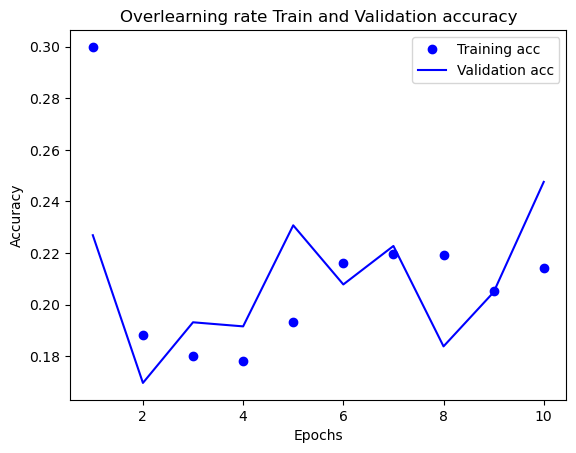

In [9]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Overlearning rate Train and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

这个模型的训练精度和验证精度很快就达到了20% ~ 30%，但无法超出这个范围。

### 使用更合理的学习率训练同一个模型

In [10]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(train_images, 
                    train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 7ms/step - loss: 0.3535 - accuracy: 0.9123 - val_loss: 0.1714 - val_accuracy: 0.9497
Epoch 2/10
375/375 [==============================] - 3s 8ms/step - loss: 0.1262 - accuracy: 0.9646 - val_loss: 0.1308 - val_accuracy: 0.9668
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1011 - accuracy: 0.9729 - val_loss: 0.1499 - val_accuracy: 0.9674
Epoch 4/10
375/375 [==============================] - 2s 4ms/step - loss: 0.0804 - accuracy: 0.9791 - val_loss: 0.1575 - val_accuracy: 0.9680
Epoch 5/10
375/375 [==============================] - 2s 4ms/step - loss: 0.0665 - accuracy: 0.9831 - val_loss: 0.1731 - val_accuracy: 0.9723
Epoch 6/10
375/375 [==============================] - 2s 4ms/step - loss: 0.0632 - accuracy: 0.9848 - val_loss: 0.2120 - val_accuracy: 0.9692
Epoch 7/10
375/375 [==============================] - 2s 4ms/step - loss: 0.0546 - accuracy: 0.9868 - val_loss: 0.1828 - val_accuracy: 0.9753
Epoch 

#### 绘制合理学习率的训练精度和验证精度

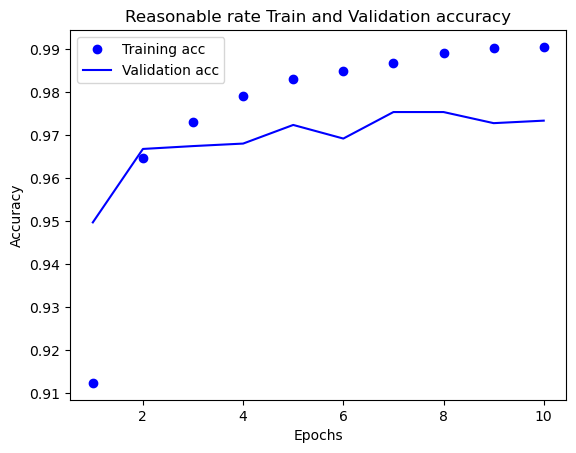

In [11]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Reasonable rate Train and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 解决模型无法训练的方法

1. 降低或提高学习率。
   - 学习率过大，可能会导致权重更新大大超出正常拟合的范围，就像前面的例子一样。
   - 学习率过小，则可能导致训练过于缓慢，以至于几乎停止。
2. 增加批量大小。
   - 如果批量包含更多样本，那么梯度将包含更多信息且噪声更少（方差更小）。

## 利用更好的架构预设

## 提高模型容量

如果成功得到了一个能够拟合的模型，验证指标正在下降，而且模型似乎具有一定的泛化能力。那么：**需要让模型过拟合**。

### 在MNIST上训练一个简单的logistics回归模型

In [12]:
model = keras.Sequential([
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_small_model = model.fit(train_images, train_labels, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.6574 - accuracy: 0.8399 - val_loss: 0.3599 - val_accuracy: 0.9039
Epoch 2/20
375/375 [==============================] - 0s 1ms/step - loss: 0.3525 - accuracy: 0.9034 - val_loss: 0.3128 - val_accuracy: 0.9124
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 0.3176 - accuracy: 0.9123 - val_loss: 0.2928 - val_accuracy: 0.9183
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 0.3015 - accuracy: 0.9164 - val_loss: 0.2838 - val_accuracy: 0.9199
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2917 - accuracy: 0.9184 - val_loss: 0.2790 - val_accuracy: 0.9239
Epoch 6/20
375/375 [==============================] - 1s 1ms/step - loss: 0.2857 - accuracy: 0.9201 - val_loss: 0.2742 - val_accuracy: 0.9260
Epoch 7/20
375/375 [==============================] - 0s 1ms/step - loss: 0.2805 - accuracy: 0.9213 - val_loss: 0.2718 - val_accuracy: 0.9252
Epoch 

#### 绘制模型的损失曲线

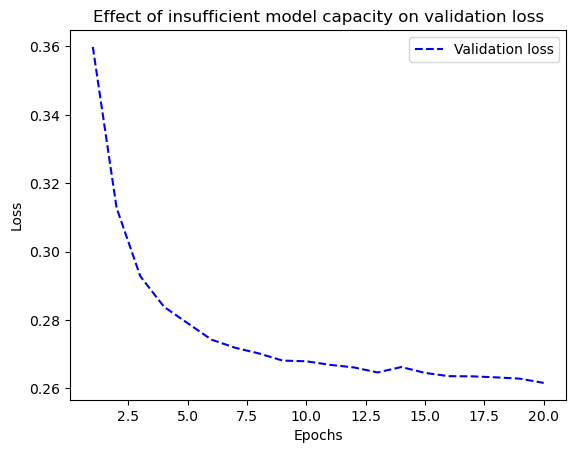

In [13]:
plt.clf()
val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--", label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

模型的验证指标似乎保持不变或者改进得非常缓慢，而不是达到峰值后扭转方向。**模型并没有达到过过拟合状态**。<p>
<font style="color: red">请记住，任何情况下都可以实现过拟合。</font>。如果模型无法实现过拟合，可能是因为模型的**表示能力**存在问题：你需要一个**容量**更大的模型，也就是一个能够存储更多信息的模型。 <p>
若要提高模型的表示能力，可以使用以下方式：
1. 添加更多的层；
2. 使用更大的层（拥有更多参数的层）；
3. 使用更合适当前问题的层类型（更好的架构预设）。

#### 训练更大的模型

In [14]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images,
    train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.3794 - accuracy: 0.8930 - val_loss: 0.1972 - val_accuracy: 0.9442
Epoch 2/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1609 - accuracy: 0.9528 - val_loss: 0.1357 - val_accuracy: 0.9622
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1104 - accuracy: 0.9671 - val_loss: 0.1204 - val_accuracy: 0.9635
Epoch 4/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0836 - accuracy: 0.9748 - val_loss: 0.1078 - val_accuracy: 0.9688
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0681 - accuracy: 0.9790 - val_loss: 0.1017 - val_accuracy: 0.9689
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0557 - accuracy: 0.9828 - val_loss: 0.1060 - val_accuracy: 0.9702
Epoch 7/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0455 - accuracy: 0.9863 - val_loss: 0.0911 - val_accuracy: 0.9747
Epoch 

#### 绘制更大模型的损失曲线

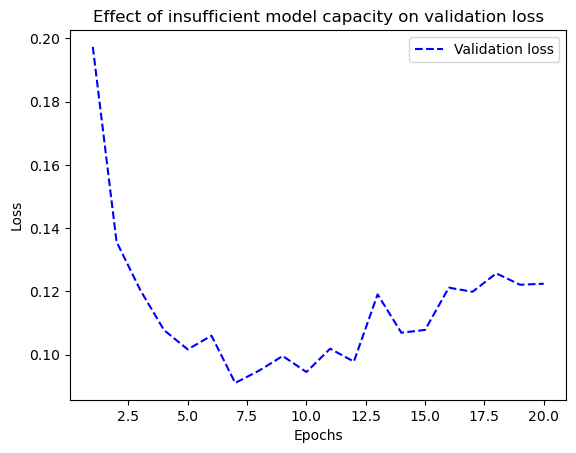

In [15]:
plt.clf()
val_loss = history_large_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--", label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

模型很快过拟合，并在8轮之后开始过拟合。

# 提高泛化能力

## 数据集管理

如果数据过于嘈杂或者本质上是离散的，比如：列表排序问题，那么深度学习将无法帮助你解决这类问题。**深度学习是曲线拟合，而不是魔法**。<p>
**必须确保使用适当的数据集**。确保拥有足够的数据。<font style="color:red">注意：</font>**需要对输入-输出空间进行密集采样**。利用更多的数据可以得到更好的模型。有时，一开始看起来无法解决的问题，在拥有更大的数据集之后就能得到解决。<p>
尽量减少标签错误。将输入可视化，以检查异常样本并核查标签。<p>
清理数据并处理缺失值。<p>
如果有很多特征，而不确定哪些特征真正有用，那么需要进行特征选择。<p>
提高数据泛化潜力的一个特别重要的方法就是**特征工程**。

## 特征工程

**特征工程**是指将数据输入模型之前，利用你自己关于数据和机器学习算法（这里指神经网络）的知识对数据进行硬编码的变换（这种变换不是模型学到的），以改善算法的效果。在多数情况下，机器学习模型无法从完全随意的数据中进行学习。呈现给模型的数据应该便于模型进行学习。

## 提前终止

在深度学习中，我们总是使用过度参数化的模型：模型自由度远远超过拟合数据潜在流形所需的最小自由度。这种过度参数化并不是问题，因为**永远不会完全拟合一个深度学习模型**。<p>

## 模型正则化

正则化方法是一组最佳实践，可以主动降低模型完美拟合训练数据的能力，**目的**是提高模型的验证性能。它之所以被称为模型的“正则化”，是因为它通常使模型变得更简单、更“规则”，曲线更平滑、更“通用”。因此，模型对训练集的针对性更弱，能够更好地近似数据的潜在流形，从而具有更强的泛化能力。<p>
模型正则化过程应该始终由一个准确的评估方法来引导。只有能够衡量泛化，你才能实现泛化。<p>
**常用的几种正则化方法**

### 缩减模型容量

一个太小的模型不会过拟合。降低过拟合最简单的方法，就是缩减模型容量，即减少模型中可学习参数的个数（由层数和每层单元个数决定）。为了让损失最小化，它必须学会对目标由预测能力的压缩表示。你的模型应该具有足够多的参数，以防欠拟合，即模型应避免记忆资源不足。在**容量过大**和**容量不足**之间，要找到一个平衡点。<p>
没有一个魔法公式能够确定最佳层数或每层的最佳大小。必须评估一系列不同的模型架构，以便为数据找到最佳的模型规模。要确定合适的模型规模，**一般的工作流程是**：
- 开始时选择相对较少的层和参数；
- 然后逐渐增加层的大小或添加新层；
- 直到这种增加对验证损失的影响变得很小。

#### 初始模型

In [41]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

# 将列表用multi-hot编码的方式转换成张量
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

x_train = vectorize_sequences(train_data)

# 将train_labels数据变为numpy
y_train= np.asarray(train_labels).astype('float32')

# 构建模型架构
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
# 构建模型的损失函数和优化器
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
# 训练模型
history_original = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4
)

Epoch 1/20
30/30 [==============================] - 3s 62ms/step - loss: 0.5330 - accuracy: 0.7808 - val_loss: 0.4035 - val_accuracy: 0.8647
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.3332 - accuracy: 0.8910 - val_loss: 0.3161 - val_accuracy: 0.8839
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2469 - accuracy: 0.9191 - val_loss: 0.2848 - val_accuracy: 0.8901
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1996 - accuracy: 0.9351 - val_loss: 0.2756 - val_accuracy: 0.8912
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1683 - accuracy: 0.9440 - val_loss: 0.2775 - val_accuracy: 0.8900
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1430 - accuracy: 0.9539 - val_loss: 0.2969 - val_accuracy: 0.8823
Epoch 7/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1208 - accuracy: 0.9617 - val_loss: 0.3291 - val_accuracy: 0.8758
Epoch 8/20
30

#### 容量更小的模型

In [42]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history_smaller_model = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4
)

Epoch 1/20
30/30 [==============================] - 1s 35ms/step - loss: 0.6539 - accuracy: 0.6343 - val_loss: 0.6198 - val_accuracy: 0.6560
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.5815 - accuracy: 0.7621 - val_loss: 0.5616 - val_accuracy: 0.7740
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 0.5115 - accuracy: 0.8488 - val_loss: 0.4959 - val_accuracy: 0.8228
Epoch 4/20
30/30 [==============================] - 0s 6ms/step - loss: 0.4298 - accuracy: 0.8927 - val_loss: 0.4197 - val_accuracy: 0.8743
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.3543 - accuracy: 0.9114 - val_loss: 0.3679 - val_accuracy: 0.8748
Epoch 6/20
30/30 [==============================] - 0s 7ms/step - loss: 0.2979 - accuracy: 0.9215 - val_loss: 0.3324 - val_accuracy: 0.8820
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.2582 - accuracy: 0.9269 - val_loss: 0.3063 - val_accuracy: 0.8863
Epoch 8/20
30/30 [=

##### 对比初始模型与较小模型的验证损失

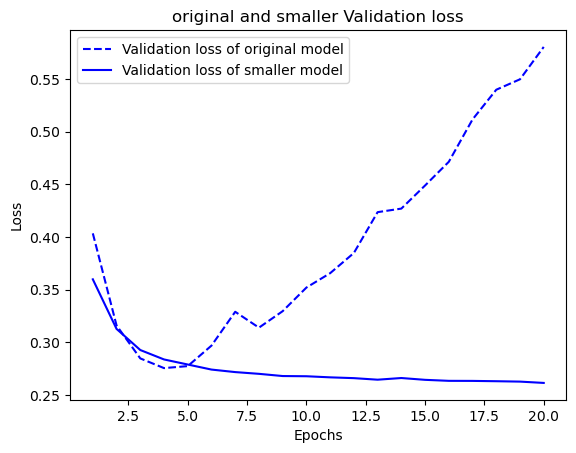

In [43]:
plt.clf()
original_loss = history_original.history["val_loss"]
smaller_loss = history_small_model.history["val_loss"]
epochs = range(1, len(original_loss) + 1)
plt.plot(epochs, original_loss, "b--", label="Validation loss of original model")
plt.plot(epochs, smaller_loss, "b", label="Validation loss of smaller model")
plt.title("original and smaller Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### 容量更大的模型

In [44]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history_larger_model = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4
)

Epoch 1/20
30/30 [==============================] - 5s 139ms/step - loss: 0.5640 - accuracy: 0.7274 - val_loss: 0.3407 - val_accuracy: 0.8694
Epoch 2/20
30/30 [==============================] - 4s 121ms/step - loss: 0.3252 - accuracy: 0.8668 - val_loss: 0.2796 - val_accuracy: 0.8852
Epoch 3/20
30/30 [==============================] - 3s 108ms/step - loss: 0.2370 - accuracy: 0.9051 - val_loss: 0.2743 - val_accuracy: 0.8907
Epoch 4/20
30/30 [==============================] - 3s 105ms/step - loss: 0.1876 - accuracy: 0.9273 - val_loss: 0.2824 - val_accuracy: 0.8872
Epoch 5/20
30/30 [==============================] - 3s 106ms/step - loss: 0.1542 - accuracy: 0.9414 - val_loss: 0.2879 - val_accuracy: 0.8884
Epoch 6/20
30/30 [==============================] - 3s 110ms/step - loss: 0.1086 - accuracy: 0.9631 - val_loss: 0.5997 - val_accuracy: 0.8142
Epoch 7/20
30/30 [==============================] - 3s 106ms/step - loss: 0.1029 - accuracy: 0.9657 - val_loss: 0.3098 - val_accuracy: 0.8846
Epoch 

##### 对比较大模型与初始模型的验证损失

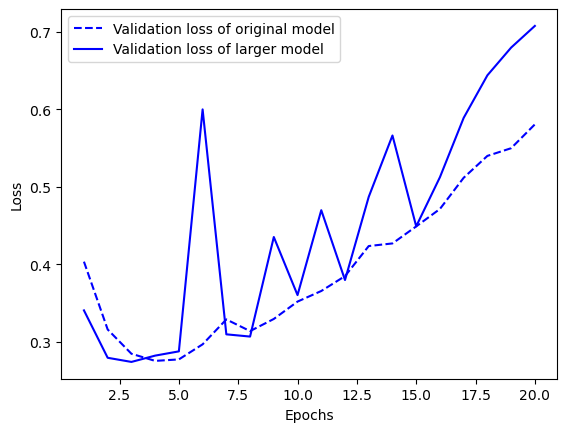

In [45]:
plt.clf()
original_loss = history_original.history["val_loss"]
larger_loss = history_larger_model.history["val_loss"]
epochs = range(1, len(original_loss) + 1)
plt.plot(epochs, original_loss, "b--", label="Validation loss of original model")
plt.plot(epochs, larger_loss, "b", label="Validation loss of larger model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 添加权重正则化

奥卡姆剃刀原理：如果一件事有两种解释，那么最可能正确的解释就是更简单的那种，即假设更少的那种。<p>
这个原理也适用于神经网络学到的模型：给定训练数据和网络架构，多组权重值（多个**模型**）都可以解释这些数据。简单模型比复杂模型更不容易过拟合。<p>
**简单模型**是指参数值分布的熵更小的模型（或参数更小的模型）。因此，降低过拟合的一种常见方法就是强制让模型权重只能取较小的值，从而限制模型的复杂度，这使得权重值的分布更加规则。这种方法叫作**权重正则化**，其实现方法是向模型损失函数中添加与较大权重值相关的**成本**。这种成本有两种形式。
- **L1正则化**：添加的成本与**权重系数的绝对值**（权重的L1范数）成正比。
- **L2正则化**：添加的成本与**权重系数的平方**（权重的L2范数）成正比。神经网络的L2正则化也叫做**权重衰减**。<p>

在Keras中，添加权重正则化的方法是向层中传入**权重正则化实例**作为关键字参数。

##### 向模型中添加L2权重正则化

In [46]:
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    layers.Dense(16, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history_l2_reg = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4
)

Epoch 1/20
30/30 [==============================] - 2s 42ms/step - loss: 0.6162 - accuracy: 0.7821 - val_loss: 0.4964 - val_accuracy: 0.8460
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.4131 - accuracy: 0.8875 - val_loss: 0.3941 - val_accuracy: 0.8802
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3388 - accuracy: 0.9093 - val_loss: 0.3702 - val_accuracy: 0.8847
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3003 - accuracy: 0.9204 - val_loss: 0.3651 - val_accuracy: 0.8847
Epoch 5/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2756 - accuracy: 0.9311 - val_loss: 0.3593 - val_accuracy: 0.8846
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2573 - accuracy: 0.9398 - val_loss: 0.3687 - val_accuracy: 0.8831
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2492 - accuracy: 0.9433 - val_loss: 0.3649 - val_accuracy: 0.8825
Epoch 8/20
30/30 

`l2(0.002)`的含义是该层权重矩阵的每个系数都会使模型总损失值增加`0.002 * weight_coefficient_value ** 2`。注意，因为**只在训练时添加**这个惩罚项，所以该模型的训练损失会比测试损失大很多。<p>
虽然原模型与添加L2正则化的模型参数个数相同，但具有L2正则化的模型比初始化模型更不容易过拟合。

##### 对比l2正则与原模型的验证损失

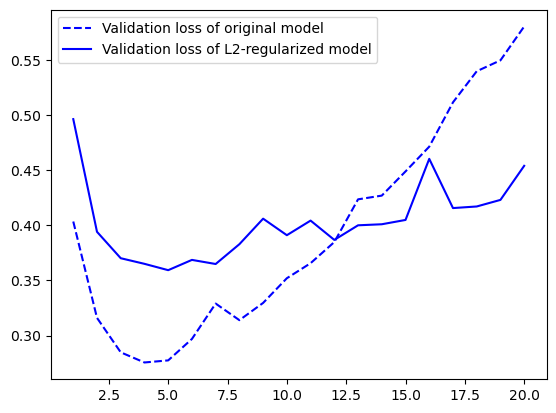

In [47]:
plt.clf()
original_loss = history_original.history["val_loss"]
l2_loss = history_l2_reg.history["val_loss"]
epochs = range(1, len(original_loss) + 1)
plt.plot(epochs, original_loss, "b--", label="Validation loss of original model")
plt.plot(epochs, l2_loss, "b", label="Validation loss of L2-regularized model")
plt.legend()
plt.show()

#### 向模型添加L1权重正则化

In [51]:
model = keras.Sequential([
    layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation="relu"),
    layers.Dense(16, kernel_regularizer=regularizers.l1(0.001), activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history_l1_reg = model.fit(
    x_trian,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4
)

Epoch 1/20
30/30 [==============================] - 2s 37ms/step - loss: 1.1564 - accuracy: 0.7249 - val_loss: 0.7365 - val_accuracy: 0.7902
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.6773 - accuracy: 0.8303 - val_loss: 0.6676 - val_accuracy: 0.8166
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.6184 - accuracy: 0.8523 - val_loss: 0.6094 - val_accuracy: 0.8581
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.5842 - accuracy: 0.8605 - val_loss: 0.5804 - val_accuracy: 0.8610
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.5642 - accuracy: 0.8633 - val_loss: 0.5747 - val_accuracy: 0.8604
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.5552 - accuracy: 0.8633 - val_loss: 0.5567 - val_accuracy: 0.8618
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.5382 - accuracy: 0.8692 - val_loss: 0.5510 - val_accuracy: 0.8657
Epoch 8/20
30/30 

##### 对比l1正则与原模型的验证损失

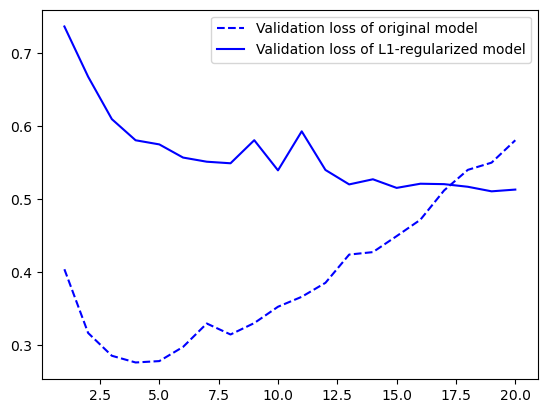

In [52]:
plt.clf()
original_loss = history_original.history["val_loss"]
l1_loss = history_l1_reg.history["val_loss"]
epochs = range(1, len(original_loss) + 1)
plt.plot(epochs, original_loss, "b--", label="Validation loss of original model")
plt.plot(epochs, l1_loss, "b", label="Validation loss of L1-regularized model")
plt.legend()
plt.show()

#### 向模型添加L1_L2权重正则化

In [53]:
model = keras.Sequential([
    layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation="relu"),
    layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history_l1_l2_reg = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4
)

Epoch 1/20
30/30 [==============================] - 2s 39ms/step - loss: 1.1693 - accuracy: 0.7293 - val_loss: 0.7295 - val_accuracy: 0.8434
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.6822 - accuracy: 0.8384 - val_loss: 0.6712 - val_accuracy: 0.8315
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.6299 - accuracy: 0.8503 - val_loss: 0.6148 - val_accuracy: 0.8564
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.5929 - accuracy: 0.8621 - val_loss: 0.6027 - val_accuracy: 0.8542
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.5785 - accuracy: 0.8638 - val_loss: 0.5876 - val_accuracy: 0.8548
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.5641 - accuracy: 0.8681 - val_loss: 0.5755 - val_accuracy: 0.8630
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.5580 - accuracy: 0.8651 - val_loss: 0.5590 - val_accuracy: 0.8644
Epoch 8/20
30/30 

##### 对比l1_l2正则化与原模型的验证损失

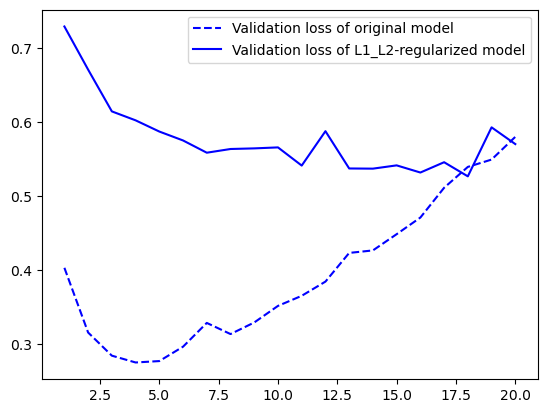

In [54]:
plt.clf()
original_loss = history_original.history["val_loss"]
l1_l2_loss = history_l1_l2_reg.history["val_loss"]
epochs = range(1, len(original_loss) + 1)
plt.plot(epochs, original_loss, "b--", label="Validation loss of original model")
plt.plot(epochs, l1_l2_loss, "b", label="Validation loss of L1_L2-regularized model")
plt.legend()
plt.show()

#### 权重正则化适用场景

权重正则化更常用于较小的深度学习模型。大型深度学习模型往往是过度参数化的，限制权重值大小对模型容量和泛化能力没有太大影响。这种情况下，应首选另一种正则化方法：**dropout**。

### 添加dropout

dropout是神经网络最常用且最有效的正则化方法之一。对某层使用dropout，就是在训练过程中随机**舍弃**该层的一些输出特征（将其设为0）。eg：某一层在训练过程中对给定输入样本的返回值应该是向量`[0.2, 0.5, 1.3, 0.8, 1.1]`。使用dropout之后，这个向量会有随机几个元素变为0，比如变为`[0, 0.5, 1.3, 0, 1.1]`。**dropout比率**是指被设为0的特征所占的比例，它通常介于0.2 ~ 0.5。测试时没有单元被舍弃，相应地，该层的输出值需要按dropout比率缩小，因为这时比训练时有更多的单元被激活，需要加以平衡。<p>
考虑一个包含某层输出的Numpy矩阵layer_output，其形状为(batch_size, features)。训练时，我们随机将矩阵中的一些值设为0。<p>
```
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)  # 训练时，将50%的输出单位设为0
```
测试时，将输出按dropout比率缩小。这里乘以0.5（因为训练时舍弃了一半的单元）。 <p>
```
layer_output *= 0.5
```
注意，为实现这一过程，还可以在训练的同时完成两个运算，而测试时保持不变。<p>
```
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)
layer_output /= 0.5
```

#### 向IMDB模型中添加dropout

In [56]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history_dropout = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4
)

Epoch 1/20
30/30 [==============================] - 2s 37ms/step - loss: 0.6450 - accuracy: 0.6259 - val_loss: 0.5543 - val_accuracy: 0.7910
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.5386 - accuracy: 0.7536 - val_loss: 0.4512 - val_accuracy: 0.8705
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.4552 - accuracy: 0.8149 - val_loss: 0.3634 - val_accuracy: 0.8801
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3903 - accuracy: 0.8521 - val_loss: 0.3256 - val_accuracy: 0.8831
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3411 - accuracy: 0.8758 - val_loss: 0.2936 - val_accuracy: 0.8886
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3007 - accuracy: 0.8980 - val_loss: 0.2837 - val_accuracy: 0.8872
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2640 - accuracy: 0.9127 - val_loss: 0.2784 - val_accuracy: 0.8885
Epoch 8/20
30/30 [=

##### 对比dropout模型和原始模型的验证损失

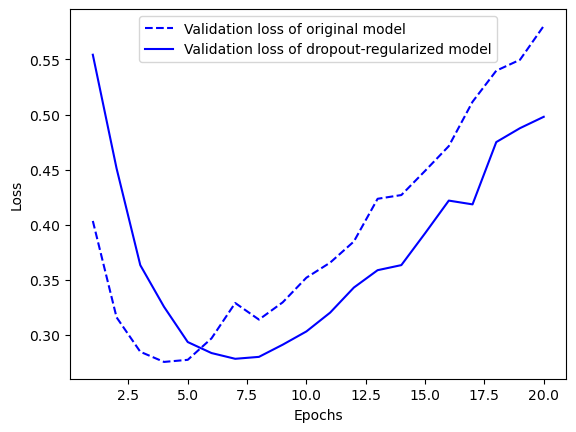

In [57]:
plt.clf()
original_loss = history_original.history["val_loss"]
dropout_loss = history_dropout.history["val_loss"]
epochs = range(1, len(original_loss) + 1)
plt.plot(epochs, original_loss, "b--", label="Validation loss of original model")
plt.plot(epochs, dropout_loss, "b", label="Validation loss of dropout-regularized model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 总结

想要将神经网络的泛化能力最大化，并防止过拟合，最常用的方法如下：
- 获取更多或更好的训练数据。
- 找到更好的特征。
- 缩减模型容量。
- 添加权重正则化（用于较小的模型）。
- 添加dropout。